# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook computes predicted expression correlations between all genes in the MultiPLIER models.

It also has a parameter set for papermill to run on a single chromosome to run in parallel (see under `Settings` below).

This notebook is not directly run. See README.md.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from random import sample
import warnings

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# reference panel
REFERENCE_PANEL = "GTEX_V8"
# REFERENCE_PANEL = "1000G"

# prediction models
## mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# ## elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

# make it read the prefix from conf.py
EQTL_MODEL_FILES_PREFIX = None

# this is the default value used in S-MultiXcan to select the
# top principal components of the expression correlation matrix
SMULTIXCAN_CONDITION_NUMBER = 30

# specifies a single chromosome value
# by default, run on all chromosomes
chromosome = None

In [4]:
# Parameters
chromosome = 12
REFERENCE_PANEL = "GTEX_V8"
EQTL_MODEL = "MASHR"


In [5]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][
        f"{EQTL_MODEL}_PREFIX"
    ]

In [6]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: MASHR / mashr_'

In [7]:
REFERENCE_PANEL_DIR = conf.PHENOMEXCAN["LD_BLOCKS"][f"{REFERENCE_PANEL}_GENOTYPE_DIR"]

In [8]:
display(f"Using reference panel folder: {str(REFERENCE_PANEL_DIR)}")

'Using reference panel folder: /opt/data/data/phenomexcan/ld_blocks/reference_panel_gtex_v8'

In [9]:
OUTPUT_DIR_BASE = (
    conf.PHENOMEXCAN["LD_BLOCKS"][f"GENE_CORRS_DIR"]
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

In [10]:
display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr'

In [11]:
assert (
    chromosome is not None
), "You have to select one chromosome (format: number between 1 and 22)"

In [12]:
chromosome = str(chromosome)

In [13]:
display(f"Working on chromosome {chromosome}")

'Working on chromosome 12'

# Load data

## MultiPLIER Z

In [14]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [15]:
len(multiplier_z_genes)

6750

In [16]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [17]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [18]:
len(multiplier_gene_obj)

6454

In [19]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [20]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
        "band": [g.band for g in _gene_obj],
        "start_position": [g.get_attribute("start_position") for g in _gene_obj],
    }
)

In [21]:
genes_info.shape

(6454, 5)

In [22]:
genes_info.head()

,name,id,chr,band,start_position
0,GAS6,ENSG00000183087,13,13q34,113820549.0
1,MMP14,ENSG00000157227,14,14q11.2,22836560.0
2,DSP,ENSG00000096696,6,6p24.3,7541617.0
3,MARCKSL1,ENSG00000175130,1,1p35.1,32333839.0
4,SPARC,ENSG00000113140,5,5q33.1,151661096.0


## Get tissues names

In [23]:
tissues = conf.PHENOMEXCAN["PREDICTION_MODELS"][f"{EQTL_MODEL}_TISSUES"].split(" ")

In [24]:
tissues[:5]

['Skin_Not_Sun_Exposed_Suprapubic',
 'Cells_EBV-transformed_lymphocytes',
 'Brain_Frontal_Cortex_BA9',
 'Kidney_Cortex',
 'Brain_Substantia_nigra']

In [25]:
assert len(tissues) == 49

# Test

In [26]:
chromosome_genes_info = genes_info[genes_info["chr"] == chromosome]
display(chromosome_genes_info)

,name,id,chr,band,start_position
20,EMP1,ENSG00000134531,12,12p13.1,13196723.0
64,FOXM1,ENSG00000111206,12,12p13.33,2857681.0
100,SOCS2,ENSG00000120833,12,12q22,93569814.0
111,FAIM2,ENSG00000135472,12,12q13.12,49866896.0
114,CD163,ENSG00000177575,12,12p13.31,7470813.0
...,...,...,...,...,...
6347,STAT2,ENSG00000170581,12,12q13.3,56341597.0
6372,ATP5G2,ENSG00000135390,12,12q13.13,53632726.0
6397,PTGES3,ENSG00000110958,12,12q13.3,56663341.0
6444,LDHB,ENSG00000111716,12,12p12.1,21635342.0


In [27]:
_gene_list_ids = sample(chromosome_genes_info["id"].tolist(), 5)
selected_chromosome_genes_obj = [Gene(ensembl_id=g_id) for g_id in _gene_list_ids]
display(len(selected_chromosome_genes_obj))

5

In [28]:
for gene_idx1 in range(0, len(selected_chromosome_genes_obj) - 1):
    gene_obj1 = selected_chromosome_genes_obj[gene_idx1]

    for gene_idx2 in range(gene_idx1 + 1, len(selected_chromosome_genes_obj)):
        gene_obj2 = selected_chromosome_genes_obj[gene_idx2]

        c = gene_obj1.get_ssm_correlation(
            gene_obj2,
        )

        print(f"{gene_obj1.name} / {gene_obj2.name}: {c}")

ORAI1 / TAC3: 0.0
ORAI1 / MRPL42: 0.0
ORAI1 / ATP5G2: 0.0
ORAI1 / ERBB3: 0.0
TAC3 / MRPL42: 0.0
TAC3 / ATP5G2: 0.07886420158954996
TAC3 / ERBB3: 0.1458895529097109
MRPL42 / ATP5G2: 0.0
MRPL42 / ERBB3: 0.0
ATP5G2 / ERBB3: -0.03223241635694202


# Compute correlation per chromosome

In [29]:
warnings.filterwarnings("error")

In [30]:
# standard checks
all_chrs = genes_info["chr"].dropna().unique()
assert all_chrs.shape[0] == 22

# select chromosome given by the user
assert chromosome in all_chrs

# run only on the chromosome specified
all_chrs = [chromosome]
genes_chr = genes_info[genes_info["chr"] == chromosome]
print(f"Number of genes in chromosome: {genes_chr.shape[0]}", flush=True)

# For testing purposes
# genes_chr = genes_chr.sample(n=20)

# sort genes by starting position to make visualizations better later
genes_chr = genes_chr.sort_values("start_position")


for chr_num in all_chrs:
    print(f"Chromosome {chr_num}", flush=True)

    # check if results exist
    output_dir = OUTPUT_DIR_BASE / "by_chr"
    output_file = output_dir / f"gene_corrs-chr{chr_num}.pkl"

    if output_file.exists():
        _tmp_data = pd.read_pickle(output_file)

        if _tmp_data.shape[0] > 0:
            print("Already run, stopping.")
            continue

    gene_chr_objs = [Gene(ensembl_id=gene_id) for gene_id in genes_chr["id"]]
    gene_chr_ids = [g.ensembl_id for g in gene_chr_objs]

    n = len(gene_chr_objs)
    n_comb = int(n * (n - 1) / 2.0)
    print(f"Number of gene combinations: {n_comb}", flush=True)

    gene_corrs = []

    pbar = tqdm(ncols=100, total=n_comb)
    i = 0
    for gene_idx1 in range(0, len(gene_chr_objs) - 1):
        gene_obj1 = gene_chr_objs[gene_idx1]

        for gene_idx2 in range(gene_idx1 + 1, len(gene_chr_objs)):
            gene_obj2 = gene_chr_objs[gene_idx2]

            pbar.set_description(f"{gene_obj1.ensembl_id} / {gene_obj2.ensembl_id}")

            try:
                # FIXME: compute the correlation of the sum of squares of the model using all
                # the available tissues; this could be problematic because for some results
                # (computed on a specific phenotype/GWAS) we might not have all the tissues
                # available, which can certainly bias the correlation estimation.
                # Since this depends on the GWAS on a specific phenotype, we should ideally have
                # one correlation matrix per GWAS. I should look at how we can improve this.
                gene_corrs.append(
                    gene_obj1.get_ssm_correlation(
                        other_gene=gene_obj2,
                        condition_number=SMULTIXCAN_CONDITION_NUMBER,
                        reference_panel=REFERENCE_PANEL,
                        model_type=EQTL_MODEL,
                    )
                )
            except Warning:
                print(
                    f"RuntimeWarning for genes {gene_obj1.ensembl_id} and {gene_obj2.ensembl_id}",
                    flush=True,
                )
                import traceback

                print(traceback.format_exc(), flush=True)
            except Exception as e:
                print(
                    f"Exception for genes {gene_obj1.ensembl_id} and {gene_obj2.ensembl_id}",
                    flush=True,
                )
                import traceback

                print(traceback.format_exc(), flush=True)
                gene_corrs.append(np.nan)

            pbar.update(1)

    pbar.close()

    # testing
    gene_corrs_flat = pd.Series(gene_corrs)
    print(f"Min/max values: {gene_corrs_flat.min()} / {gene_corrs_flat.max()}")
    assert gene_corrs_flat.min() >= -1.001
    assert gene_corrs_flat.max() <= 1.001

    # save
    # FIXME: consider saving only the condenced matrix here. See here for
    # more details: https://github.com/greenelab/phenoplier/pull/38#discussion_r634600813
    gene_corrs_data = squareform(np.array(gene_corrs, dtype=np.float64))
    np.fill_diagonal(gene_corrs_data, 1.0)

    gene_corrs_df = pd.DataFrame(
        data=gene_corrs_data,
        index=gene_chr_ids,
        columns=gene_chr_ids,
    )

    output_dir.mkdir(exist_ok=True, parents=True)
    display(output_file)

    gene_corrs_df.to_pickle(output_file)

Number of genes in chromosome: 389
Chromosome 12
Number of gene combinations: 75466


ENSG00000196387 / ENSG00000256223: 100%|████████████████████| 75466/75466 [6:07:03<00:00,  3.43it/s]

Min/max values: -0.9982967105515688 / 0.9969947433321128


PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/gene_corrs-chr12.pkl')

# Testing

In [31]:
gene_corrs_df.shape

(389, 389)

In [32]:
gene_corrs_df.head()

,ENSG00000120645,ENSG00000111181,ENSG00000171840,ENSG00000060237,ENSG00000002016,ENSG00000082805,ENSG00000111186,ENSG00000006831,ENSG00000151062,ENSG00000151065,...,ENSG00000132341,ENSG00000198598,ENSG00000177169,ENSG00000182870,ENSG00000177084,ENSG00000176894,ENSG00000196458,ENSG00000198393,ENSG00000196387,ENSG00000256223
ENSG00000120645,1.000000,-0.049417,-0.056575,0.048659,0.029227,0.000990,0.039116,-0.047698,-0.018082,-0.068448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000111181,-0.049417,1.000000,-0.021797,0.005337,0.065544,-0.024246,0.109825,-0.056594,0.004523,-0.012559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000171840,-0.056575,-0.021797,1.000000,-0.009132,-0.139078,-0.074546,0.042766,0.112736,0.050263,-0.007610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000060237,0.048659,0.005337,-0.009132,1.000000,-0.039166,0.023380,-0.113647,-0.020968,-0.026575,0.029823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000002016,0.029227,0.065544,-0.139078,-0.039166,1.000000,0.021313,-0.120371,-0.057250,0.112586,0.056742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
_min_val = gene_corrs_df.min().min()
display(_min_val)
assert _min_val >= -1.0

-0.9982967105515688

In [34]:
_max_val = gene_corrs_df.max().max()  # this captures the diagonal
display(_max_val)
assert _max_val <= 1.0

1.0

In [35]:
# check upper triangular values
assert len(gene_corrs) == int(genes_chr.shape[0] * (genes_chr.shape[0] - 1) / 2)

In [36]:
gene_corrs = pd.Series(gene_corrs)

In [37]:
gene_corrs.describe()

count    75466.000000
mean         0.000217
std          0.056939
min         -0.998297
25%          0.000000
50%          0.000000
75%          0.000000
max          0.996995
dtype: float64

In [38]:
gene_corrs_quantiles = gene_corrs.quantile(np.arange(0, 1, 0.05))
display(gene_corrs_quantiles)

0.00   -0.998297
0.05   -0.019678
0.10    0.000000
0.15    0.000000
0.20    0.000000
0.25    0.000000
0.30    0.000000
0.35    0.000000
0.40    0.000000
0.45    0.000000
0.50    0.000000
0.55    0.000000
0.60    0.000000
0.65    0.000000
0.70    0.000000
0.75    0.000000
0.80    0.000000
0.85    0.000000
0.90    0.000000
0.95    0.024915
dtype: float64

## Plot: distribution

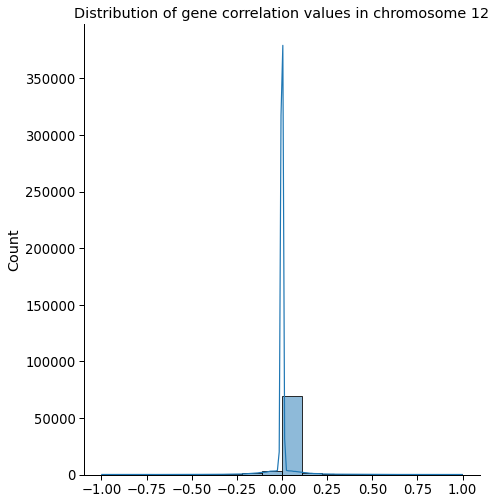

In [39]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(gene_corrs, kde=True, height=7)
    g.ax.set_title(
        f"Distribution of gene correlation values in chromosome {chromosome}"
    )

## Plot: heatmap

In [40]:
vmin_val = min(-0.05, gene_corrs_quantiles[0.10])
vmax_val = max(0.05, gene_corrs_quantiles[0.90])
display(f"{vmin_val} / {vmax_val}")

'-0.05 / 0.05'

Text(0.5, 1.0, 'Gene correlations in chromosome 12')

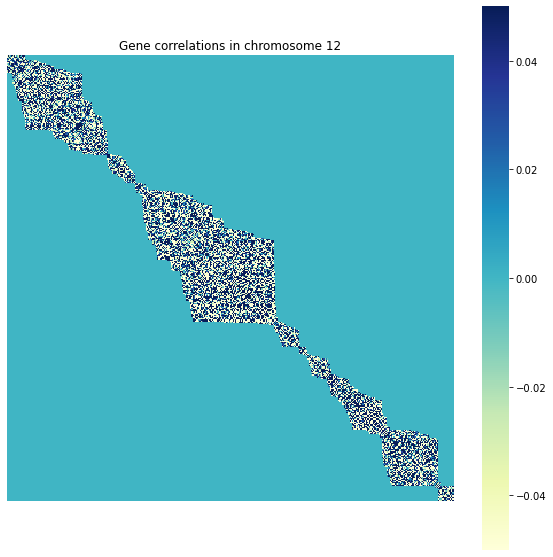

In [41]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    gene_corrs_df,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="YlGnBu",
    ax=ax,
)
ax.set_title(f"Gene correlations in chromosome {chromosome}")